## Requirements of Topic C. Sentiment Analysis

Text sentiment analysis (TSA) refers to identification of sentiments, usually positive or negative, expressed in text or document. One may want to develop deep learning techniques for TSA:
1. To deal with domain adaptation, that is, how can one adapt a network train on one domain to work in another domain
2. To compare the performance of different Transformers architectures
3. To deal with small datasets, that is, with insufficient number of training samples


References:
1. T. Gui et al., “Long Short-Term Memory with Dynamic Skip Connections,” Proc. AAAI Conf. Artif. Intell., 2019, doi: 10.1609/aaai.v33i01.33016481.
2. A. L. Maas, R. E. Daly, P. T. Pham, D. Huang, A. Y. Ng, and C. Potts, “Learning word vectors for sentiment analysis,” in ACL-HLT 2011 - Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, 2011.
3. X. Zhang, J. Zhao, and Y. Lecun, “Character-level convolutional networks for text classification,” in Advances in Neural Information Processing Systems, 2015.

<a id="content"></a>
## Contents
* [0. Dependencies](#dependencies)
* [1. Dataset Processing & Exploration](#dataset)
    * [1.1. Loading Data](#loading)
    * [1.2. Text Cleaning](#cleaning)
    * [1.3. Dataset Visualization](#visualization)
    * [1.4. Vectorization](#vectorization)
* [2. Models](#models)
    * [2.1. Naive Bayes Classfication](#naive)
    * [2.2. Long Short Term Memory (LSTM) Classification](#lstm)
    * [2.3. MultiChannelCNN](#mchcnn)
    * [2.4. CNN_LSTM](#cnnlstm)
* [3. Transformers](#transformers)
    * [3.1 BERT](#bert)
    * [3.2. DistilBERT](#distilbert)
    * [3.3. DistilRoBERTa](#distilroberta)
    * [3.4. BART](#bart)
    * [3.5. ALBERT](#AlBERT)
    * [3.6. ALBERT for Classification](#ALBERTCls)
    * [3.7. DeBERTa](#DeBERTa)
    * [3.8. Funnel](#Funnel)
    * [3.9. OpenAI GPT2](#gpt2)


Note: Salesforce\CTRL takes too much RAM to train, XLMRobertaModel doesn't train with the task, T5 doesn't perform well

TODO:
1. Add ROBERTA & BERT for stanford tree bank
2. Find a way to incorporate highlighter

<a id="dependencies"></a>
## [0. Dependencies](#content)

Import necessary libraries.
    

In [1]:
!pip install langdetect==1.0.9
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=33b6cd98049d94d051e63797916d74a4ed6a358f5c8f721e57205d6f01a19812
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
import numpy as np
import shutil # OS interaction
import pickle # For saving and reloading data and models
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For text cleaning - language detection
from langdetect import detect
from langdetect import DetectorFactory

# For text cleaning - basic cleaning
from bs4 import BeautifulSoup # For removing html components
import string # For removing punctuation
import re 

# For text preprocessing - stem & lemmatize
import nltk
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# For text visualization
from collections import Counter # Count word frequency
# For word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


# For dataset split
from sklearn.model_selection import train_test_split

# For text vectorization and label
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Base Model
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# For neural network definition
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# For MCHCNN
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, concatenate, Dense, Embedding, Dropout

# For LSTM 
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import LSTM, SpatialDropout1D

# For CNN-LSTM
from tensorflow.keras.layers import BatchNormalization, Bidirectional

# For DistilBERT
from transformers import DistilBertTokenizer, TFAutoModel, AdamWeightDecay

# For TextBlob
from textblob import TextBlob

# For hyper-parameter selection
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# For easy progress bar
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

<a id="dataset"></a>
## [1. Dataset Processing & Exploration](#content)

Datasets given by requirements:
1. [Stanford Sentiment Treebank(Not in use)](https://www.kaggle.com/atulanandjha/stanford-sentimenttreebank-v2-sst2)
2. [IMDB movie review dataset(Used in the notebook)](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50kmovie-reviews)
3. [YELP review dataset(Not in use)](http://xzh.me/docs/charconvnet.pdf)

<a id="loading"></a>
### [1.1. Loading Data](#content)
We load the dataset directly from kaggle using pandas.

In [3]:
# Load the dataset
# Please replace the path with the actual path to the IMDB dataset
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<a id="cleaning"></a>
### [1.2. Text Cleaning](#content)

In the text cleaning section, we take the following steps on the entire dataset:

1. Language Recognition: To remove non-English contents
2. Basic Cleaning: Removes stopwords, special characters, single characters, multiple spaces, possible emojis and links
3. Stemming & Lemmatization: As different models might have different requirements on input, we want to examine the result of applying stemming and lemmatization on different models to find the best result.


#### Language detection

Using [langdetect](https://pypi.org/project/langdetect/) packet to remove non-english content from the review

In [4]:
DetectorFactory.seed = 48 # set seed for reproduction

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

data['language'] = data['review'].progress_apply(language_detection)
data['language'].value_counts()

100%|██████████| 50000/50000 [06:24<00:00, 129.99it/s]


language
en    49999
id        1
Name: count, dtype: int64

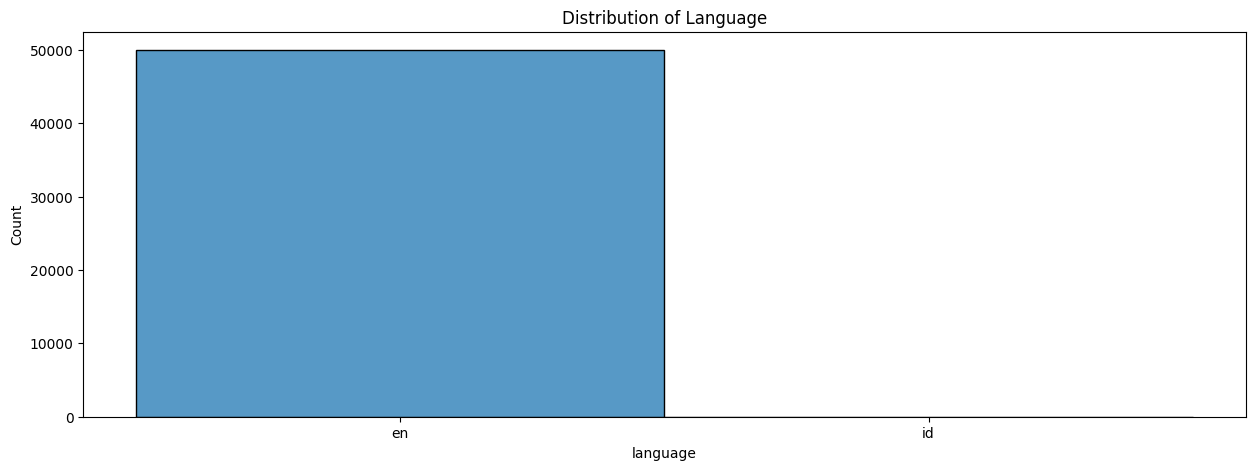

In [5]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=data['language'])
plt.title("Distribution of Language")
plt.show()

Since there's only 1 review identified as non-english, we assume the dataset is english-based, and no non-English content is present.

#### Basic Cleaning
Removes stopwords, special characters, single characters and multiple spaces.



In [6]:
# Text preprocessing
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()



def clean_text(text):
    # Uniode text
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    
    text = text.lower() # Lowercase text
    
    text = re.sub(r'\W', ' ', text) # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    text = re.sub(r'#', '', text)# Remove hashtag sign
    
    # Remove possible links
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    
    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"there\'s", "there is", text)
    text = re.sub(r"nothing\'s", "nothing is", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)
    return text

def remove_punc(text):
    text =  text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split()])
    return text

additional_stopwords = ["``","''","br",'--', 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb', 'e']
STOPWORDS = set(stopwords.words('english')+additional_stopwords)
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # Remove stopwords from text
    return text

In [7]:
data['cleaned_review'] = data['review'].progress_apply(strip_html).apply(clean_text).apply(decontracted).apply(remove_punc).apply(remove_stopwords)
data.head()

100%|██████████| 50000/50000 [00:11<00:00, 4175.22it/s]


,review,sentiment,language,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...


#### Stemming
Stemming adheres to predefined rules to remove suffixes like "ing," "ed," "es," and others. While it's fast, it may result in peculiar words. Doing stemming helps reduce noise in the corpus

In [8]:
def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

In [9]:
data['cleaned_stemmed_review'] = data['cleaned_review'].progress_apply(stem_text)
data.head()

100%|██████████| 50000/50000 [05:14<00:00, 158.84it/s]


,review,sentiment,language,cleaned_review,cleaned_stemmed_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...,petter mattei love time money visual stun film...


In [10]:
print("========== number of words in the corpus ==========")

print(f"original: {data['review'].apply(lambda x: len(x.split())).sum()}")

print(f"after basic cleaning: {data['cleaned_review'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {data['cleaned_stemmed_review'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 11557847
after basic cleaning: 5965854
after stemming: 5969055


After cleaning and stemming, the noise of the text corpus decreased largely

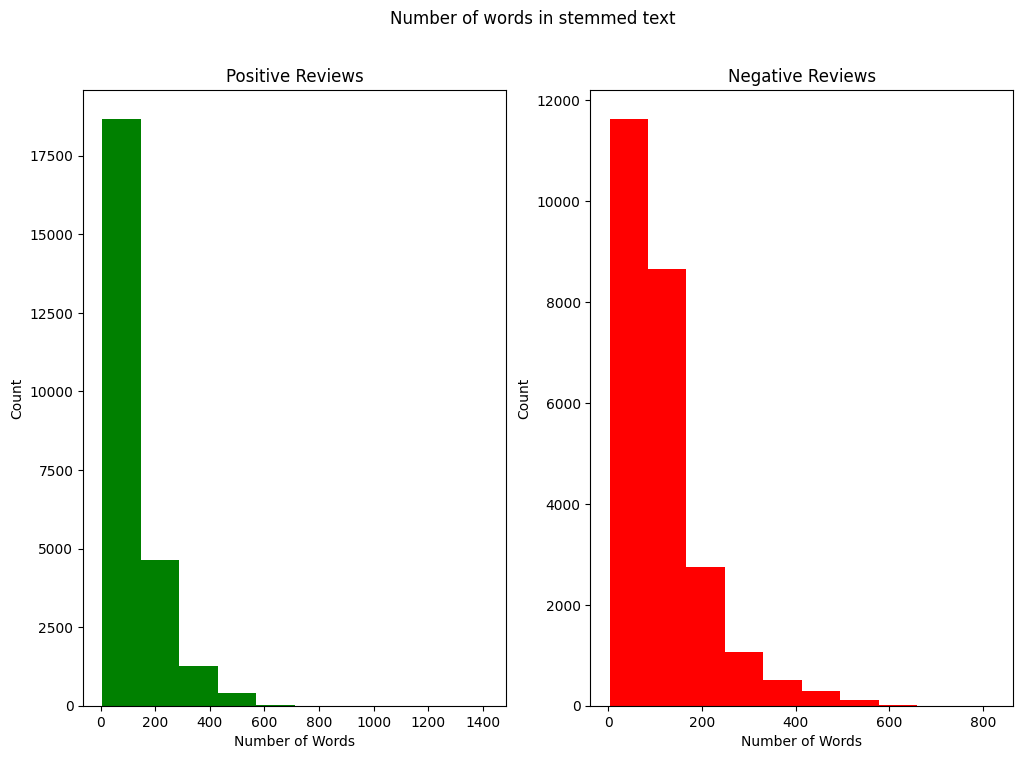

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=data[data['sentiment'] == 'positive']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=data[data['sentiment'] == 'negative']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in stemmed text')
plt.show()

<a id="visualization"></a>
### [1.3. Data Visualization](#content)

Here we do some basic data visualization to get a big picture of the dataset

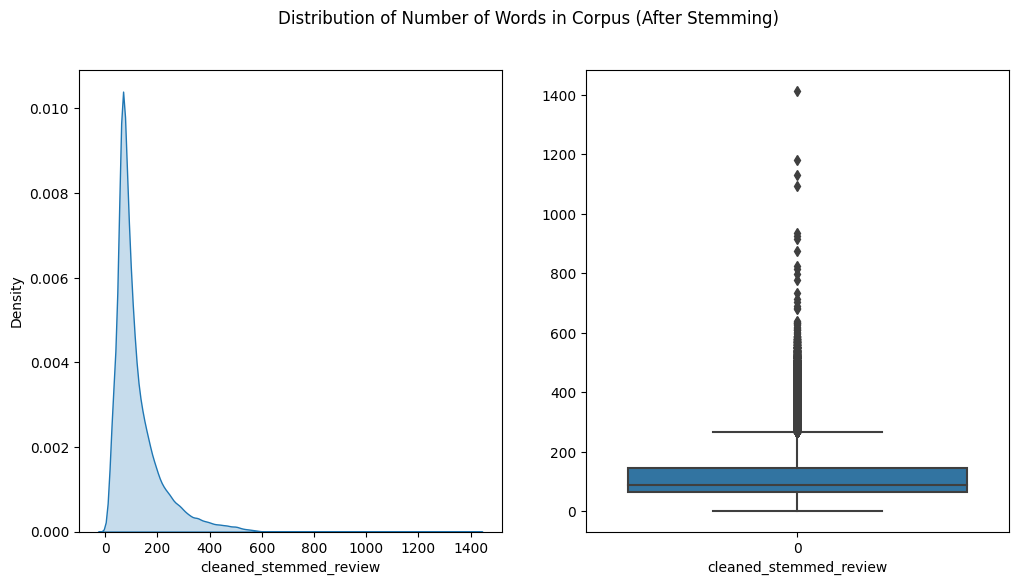

In [12]:
# Investigate word distribution
num_words_train = data['cleaned_stemmed_review'].apply(lambda x: len(x.split()))
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.kdeplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), fill=True, ax=axes[0])
sns.boxplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), ax=axes[1])
axes[1].set_xlabel("cleaned_stemmed_review")
fig.suptitle('Distribution of Number of Words in Corpus (After Stemming)')
plt.show()

In [13]:
# Find the top 25 most common words
word_list = data['cleaned_review'].str.split()
top = Counter([item for sublist in word_list for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['common_words','count']
temp.style.background_gradient(cmap='Blues')

,common_words,count
0,movie,87937
1,film,79674
2,one,53585
3,like,40160
4,good,29737
5,time,25100
6,even,24855
7,would,24599
8,story,23110
9,really,23089


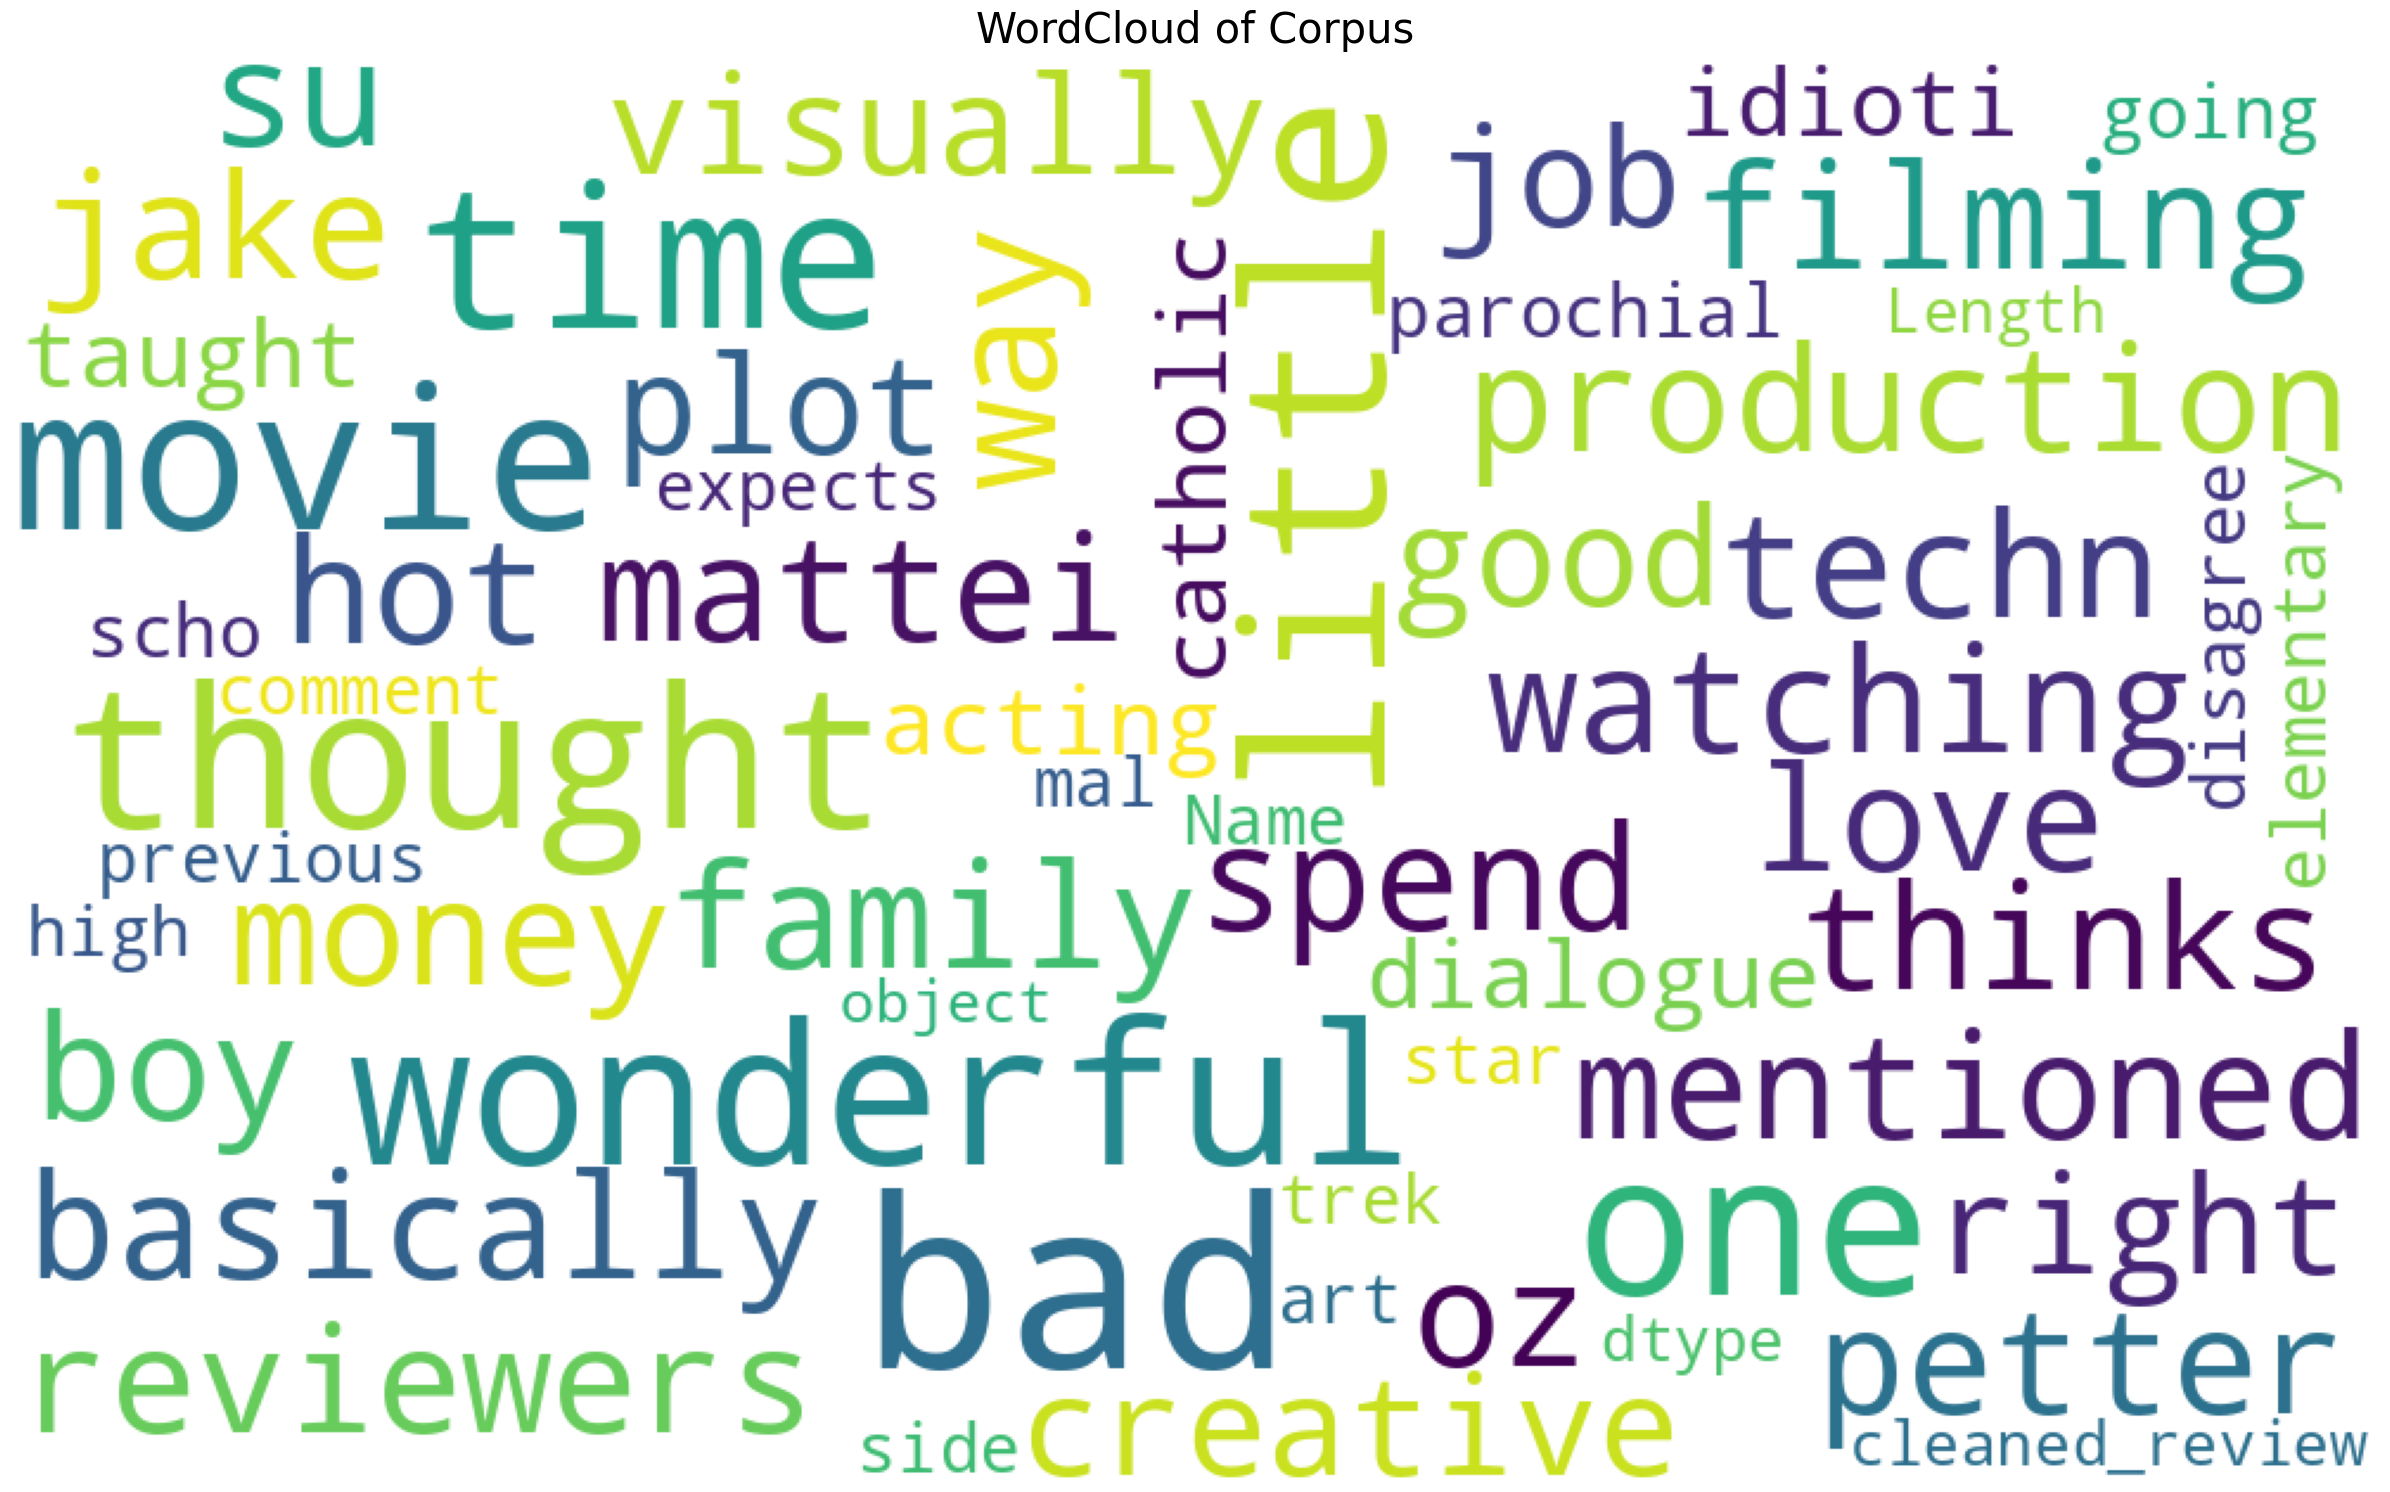

In [14]:
# Plot wordcloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 5,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

<a id="vectorization"></a>
### [1.4. Vectorization](#content)

For training with classifiers, vectorization is necessary. We are also going to split dataset into train, validation & test in this section before tokenization, and apply vector transform only on train data to avoid data leak.

#### Train, Validation, Test split

Before splitting the dataset, let's convert the sentiment column to label and examine the balanceness of the label

In [15]:
features = ['cleaned_review', 'cleaned_stemmed_review']
target='sentiment'

# Converting categorical labels to numbers.
data[target] = pd.get_dummies(data[target]).values
print('Shape of label tensor:', data[target].shape)

# Show label counts
data[target].value_counts()

Shape of label tensor: (50000,)


sentiment
False    25000
True     25000
Name: count, dtype: int64

Since the Y label is well balanced, we don't need to under/over sample to balance the dataset, let's move on to train/test/cv split

In [16]:
# Split the dataset into 0.6:0.2:0.2 by default
# Use stratify to ensure that label are still balanced after split
def split_data(X, Y, test_size=0.2, val_size = 0.2, seed=42):
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y,
                                                        test_size = test_size, 
                                                        random_state = seed, stratify=Y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                        y_train_valid,
                                                        test_size = val_size/(1-test_size), 
                                                        random_state = seed, stratify=y_train_valid)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data[features], data[target])
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_val.shape}")
print(f"Shape of y_valid: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (30000, 2)
Shape of y_train: (30000,)
Shape of X_valid: (10000, 2)
Shape of y_valid: (10000,)
Shape of X_test: (10000, 2)
Shape of y_test: (10000,)


#### Vectorization
In NLP, there are many text vectorization methods. We are going to apply the following techniques and collect the data for future use.

1. Index Vectorization: converts each word in the text to an index based on its position in a word index vocabulary
2. Bag of Words:
3. Tfidf: Term Frequency-Inverse Document Frequency (TF-IDF) vectorization is a method commonly used in NLP to represent text data numerically, giving more weight to words that are important within a specific document while considering their frequency across the entire corpus.

In [17]:
X_train_dict = {}
X_val_dict = {}
X_test_dict = {}

methods = ['index', 'bow', 'tfidf']

# Max number of words in each sequence, choose 600 as most of the reviews is under 600 number of words
MAX_SEQUENCE_LENGTH = 500 # Also length of feature
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# This is fixed.
EMBEDDING_DIM = 100

With index vectorization, we tokenize the cleaned texts and convert them into sequences of numbers. We then pad the sequences to make them of equal length.

In [18]:
def keras_token_transform(tokenizer, X):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    return X

# keras defaults to index vectorization
def index_vectorization(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    
    X_train_vec = keras_token_transform(tokenizer, X_train)
    X_val_vec = keras_token_transform(tokenizer, X_val)
    X_test_vec = keras_token_transform(tokenizer, X_test)
    return X_train_vec, X_val_vec, X_test_vec

method = methods[0]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = index_vectorization(X_train[feature].values, X_val[feature].values, X_test[feature].values) 
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

With bag of words vectorization

In [19]:
def bow_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_vec =  clf.transform(X_train).toarray()
    X_val_vec = clf.transform(X_val).toarray()
    X_test_vec = clf.transform(X_test).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[1]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = bow_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

With tfidf vectorization

In [20]:
def tfidf_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_cnt_vec =  clf.transform(X_train)
    X_valid_cnt_vec = clf.transform(X_val)
    X_test_cnt_vec = clf.transform(X_test)
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cnt_vec)
    X_train_vec = tf_transformer.transform(X_train_cnt_vec).toarray()
    X_val_vec = tf_transformer.transform(X_valid_cnt_vec).toarray()
    X_test_vec = tf_transformer.transform(X_test_cnt_vec).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[2]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = tfidf_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    #print(f"First example of {feature} after {method} vectorization")
    #print(X_train_dict[f'{method}_{feature}'][0])

In [21]:
for method in methods:
    for feature in features:
        print(f"Shape of {feature} X_train after {method} vectorization", X_train_dict[f'{method}_{feature}'].shape)

Shape of cleaned_review X_train after index vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after index vectorization (30000, 500)
Shape of cleaned_review X_train after bow vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after bow vectorization (30000, 500)
Shape of cleaned_review X_train after tfidf vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after tfidf vectorization (30000, 500)


In [22]:
def save_data(data_dict, file_name):
    # Open the file in binary write mode and save the dictionary
    with open(file_name, 'wb') as file:
        pickle.dump(data_dict, file)

def load_data(file_name):
    loaded_data = {}
    # Open the file in binary read mode and load the dictionary
    with open(file_name, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

For fast reloading of the data

In [23]:
# Save vectorized data
save_data(X_train_dict, "x_train_dict.pkl")
save_data(X_test_dict, "x_test_dict.pkl")
save_data(X_val_dict, "x_val_dict.pkl")

In [24]:
X_train_dict = load_data("x_train_dict.pkl")
X_test_dict = load_data("x_test_dict.pkl")
X_val_dict = load_data("x_val_dict.pkl")

<a id="models"></a>
## [2. Models](#content)

In this section, we will use Naive Bayes as the base model to compare neural network performance

<a id="naive"></a>
### [2.1. Naive Bayes Classification](#content)

referencing print_eval in the transformer section: [Transformer Preprocessing](#trans_preproc)

In [25]:
def print_eval(y_test, result, title, ax=None):
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(6,6))
    
    confuse = metrics.confusion_matrix(y_test, result)
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    sns.heatmap(confuse, annot = True, fmt='d', ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print(f"---------- Evaluation Metrics for {title} ----------\n")
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}\n'.format(average_precision))

def naive_bayes_train_test(x_train, y_train, x_test, y_test, ax, title):

    model = MultinomialNB().fit(x_train, y_train)
    result = model.predict(x_test)
    
    print_eval(y_test, result, title, ax)

---------- Evaluation Metrics for index_cleaned_review ----------

F1 score: 0.635
Precision score: 0.503
Recall score: 0.862
Average precision-recall score: 0.503

---------- Evaluation Metrics for index_cleaned_stemmed_review ----------

F1 score: 0.634
Precision score: 0.503
Recall score: 0.857
Average precision-recall score: 0.502

---------- Evaluation Metrics for bow_cleaned_review ----------

F1 score: 0.814
Precision score: 0.829
Recall score: 0.799
Average precision-recall score: 0.763

---------- Evaluation Metrics for bow_cleaned_stemmed_review ----------

F1 score: 0.816
Precision score: 0.828
Recall score: 0.804
Average precision-recall score: 0.764

---------- Evaluation Metrics for tfidf_cleaned_review ----------

F1 score: 0.819
Precision score: 0.836
Recall score: 0.803
Average precision-recall score: 0.769

---------- Evaluation Metrics for tfidf_cleaned_stemmed_review ----------

F1 score: 0.819
Precision score: 0.835
Recall score: 0.804
Average precision-recall scor

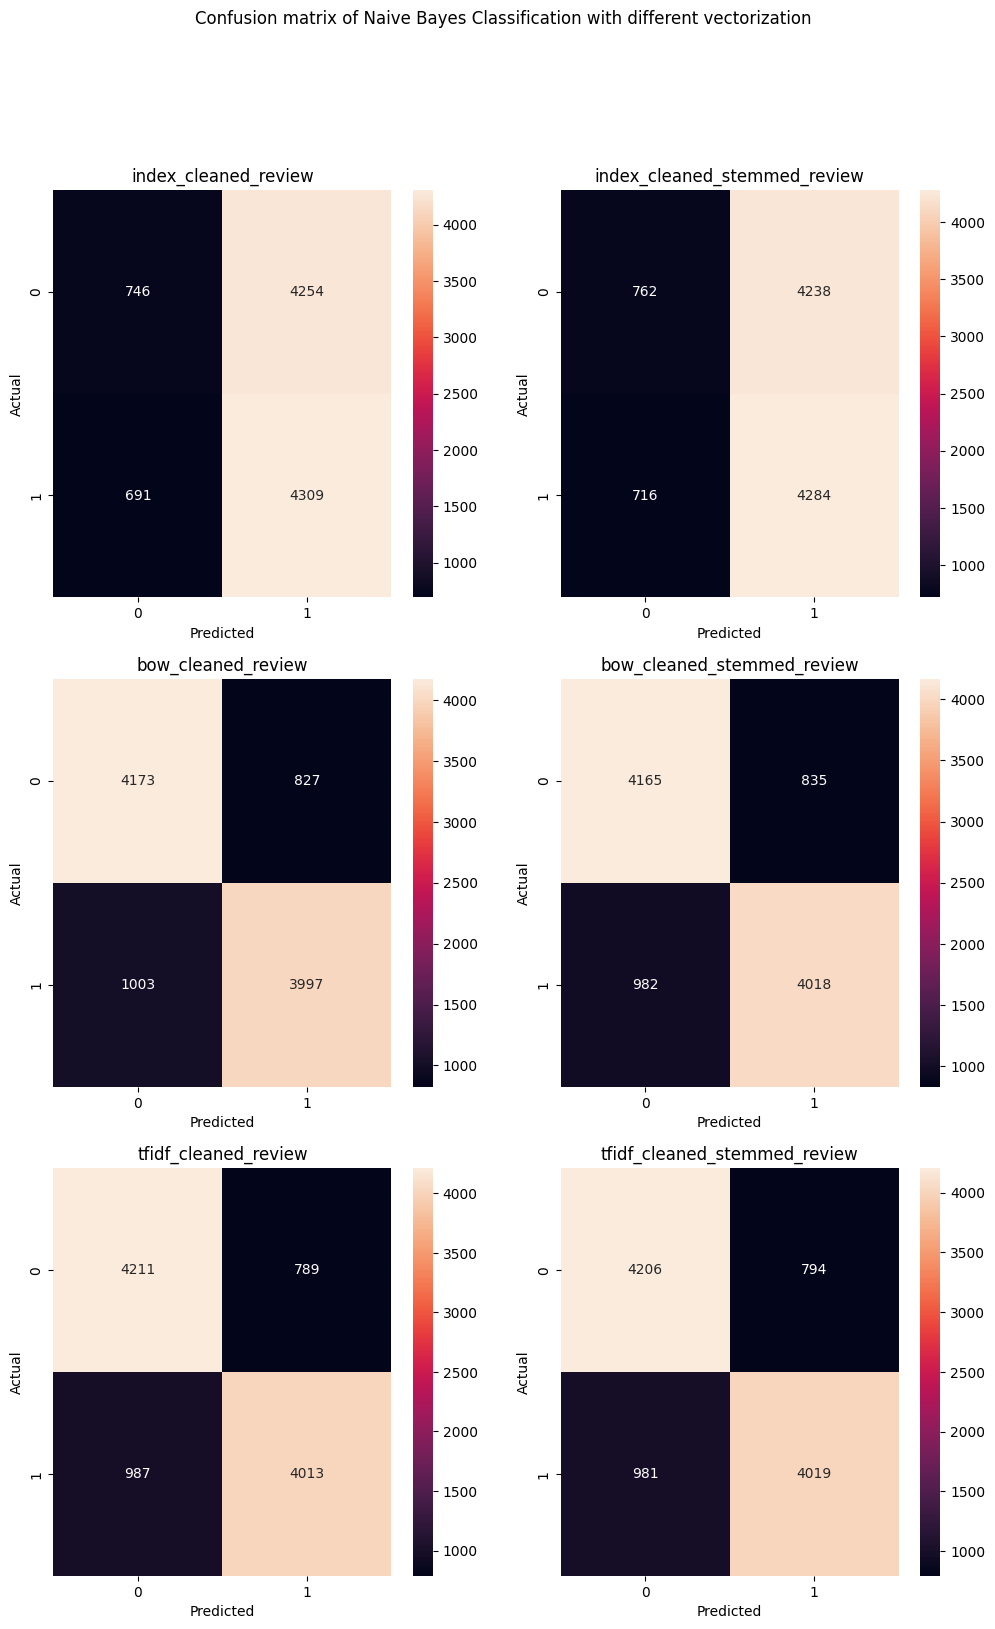

In [26]:
fig, axes = plt.subplots(len(methods), len(features), figsize=(6*len(features), 6*len(methods)))
for i in range(len(methods)):
    for j in range(len(features)):
        method = methods[i]
        feature = features[j]
        naive_bayes_train_test(X_train_dict[f'{method}_{feature}'], y_train, X_test_dict[f'{method}_{feature}'], y_test, ax=axes[i,j], title=f'{method}_{feature}')
        
fig.suptitle(f"Confusion matrix of Naive Bayes Classification with different vectorization")
plt.show()

NaiveBayes works the best with stemmed text using tfidf vectorization, which also confirmed our assumption that stemming text will reduce the noise in the data, which in turn improves model performance

<a id="lstm"></a>
### [2.2. Long Short Term Memory (LSTM) Classification](#content)

Since we are running high-dimensional large dataset, using TPU will significantly reduce training time, we are using the TPU on kaggle and training on stemmed text with tfidf vectorization

In [27]:
# utility function for plotting
def history_plot(history):
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
    # Get the training loss and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the training accuracy and validation accuracy from the history object
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss and accuracy on a single ax
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def predict_eval(model, X_test, y_test, title):
    # Generate predictions for the test dataset and plot cf_mtx
    result = model.predict(X_test)
    result = result>0.5

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    print_eval(y_test, result, title, ax)
    plt.show()

In [28]:
try:
    tpu_cluster = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu_cluster.master())
except ValueError:
    tpu_cluster = None # It assigns None to the tpu_cluster variable, indicating that no TPU is available

if tpu_cluster: # is not None
    tf.config.experimental_connect_to_cluster(tpu_cluster)
    tf.tpu.experimental.initialize_tpu_system(tpu_cluster)
    dist_strategy = tf.distribute.TPUStrategy(tpu_cluster) # use a distribution strategy related to the presence of TPU 
else: # is None
    dist_strategy = tf.distribute.get_strategy() # use a distribution strategy related to the absence of TPU 

print('The number of Replica involved in strategy :', dist_strategy.num_replicas_in_sync)

The number of Replica involved in strategy : 1


In [29]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
# Create the model
with dist_strategy.scope():
    lstm_model_index = create_lstm_model()

lstm_model_index.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_dict['index_cleaned_stemmed_review'].shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                         y_train,
                         epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val),
                        callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 700s 742ms/step - loss: 0.3596 - accuracy: 0.8450 - val_loss: 0.3020 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 692s 738ms/step - loss: 0.1990 - accuracy: 0.9257 - val_loss: 0.3177 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 693s 738ms/step - loss: 0.1296 - accuracy: 0.9543 - val_loss: 0.3684 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 694s 740ms/step - loss: 0.0623 - accuracy: 0.9802 - val_loss: 0.3943 - val_accuracy: 0.8880 - lr: 2.0000e-04
Epoch 5/10
938/938 [==============================] - 694s 740ms/step - loss: 0.0438 - accuracy: 0.9864 - val_loss: 0.4337 - val_accuracy: 0.8876 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 697s 743ms/step - loss: 0.0311 - accuracy: 0.9911 - val_loss: 0.4794 - val_accuracy: 0.8890 - lr: 4.0000e-05


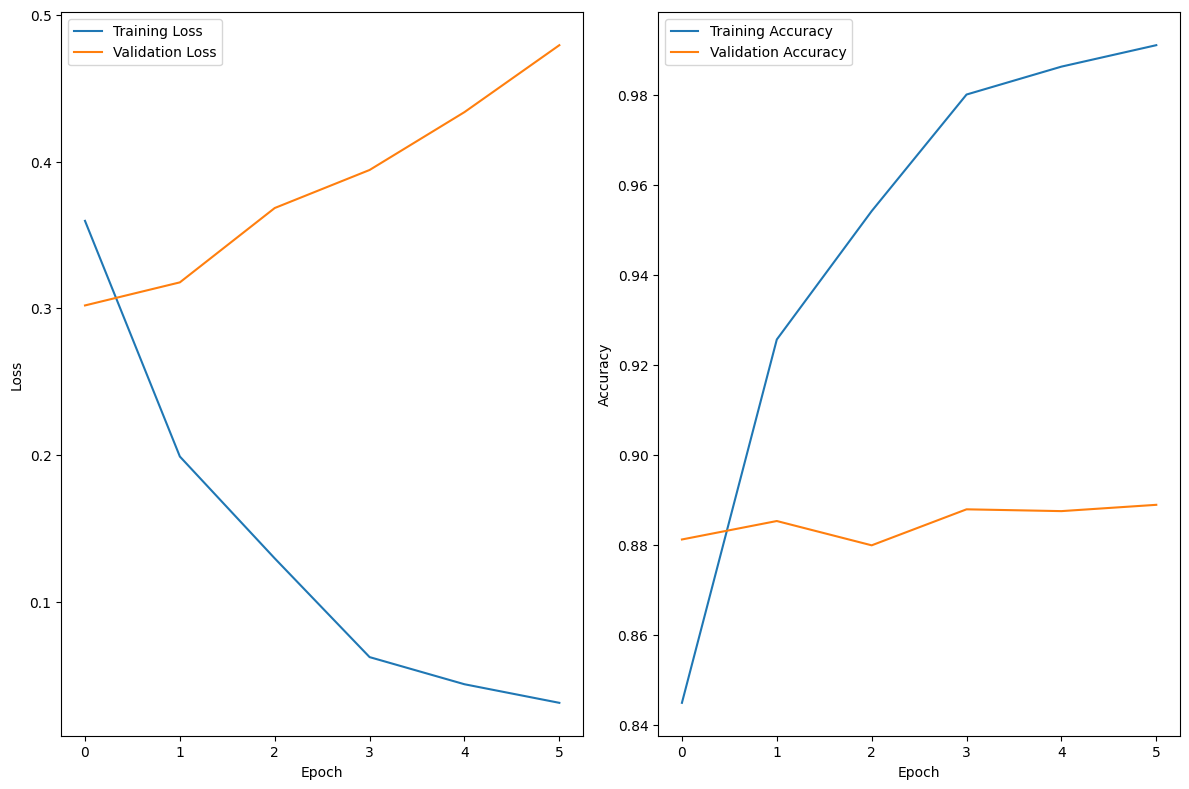

In [32]:
# Show Plot
history_plot(history)

313/313 [==============================] - 30s 94ms/step
---------- Evaluation Metrics for lstm_index_cleaned_stemmed_review ----------

F1 score: 0.879
Precision score: 0.888
Recall score: 0.870
Average precision-recall score: 0.838



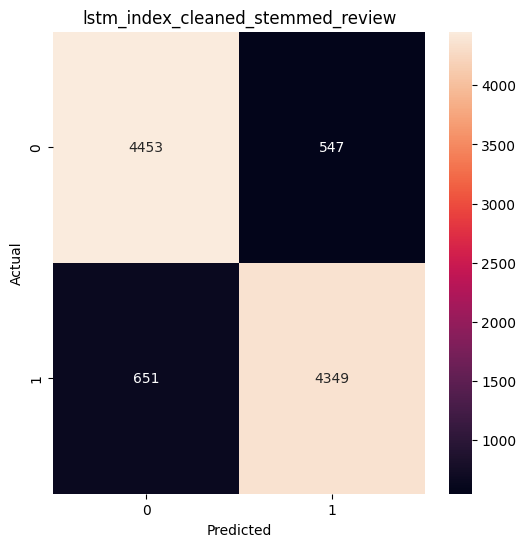

In [33]:
# Evaluation with test set
predict_eval(lstm_model_index, X_test_dict['index_cleaned_stemmed_review'], y_test, 'lstm_index_cleaned_stemmed_review')

We define an LSTM model, compile it, and then train it using our training data.

<a id="mchcnn"></a>
### [2.3. MultiChannelCNN](#content)

In [34]:
def create_mchcnn_model():
    input1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding1 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(conv1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)

    input2 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding2 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2= Flatten()(pool2)

    input3 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding3 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)

    input4 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding4 = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(input4)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(embedding4)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)

    conc = concatenate([flat1, flat2, flat3, flat4])
    dense1 = Dense(128, activation='relu')(conc)
    drop1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(drop1)

    multi_channel_cnn = Model(inputs=[input1, input2, input3, input4], outputs=output)
    multi_channel_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return multi_channel_cnn

with dist_strategy.scope():
    multi_channel_cnn = create_mchcnn_model()

multi_channel_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                              

In [35]:
X_train_selected = X_train_dict['index_cleaned_stemmed_review']
X_val_selected = X_val_dict['index_cleaned_stemmed_review']
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_selected.shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = multi_channel_cnn.fit(
    [X_train_selected, X_train_selected, X_train_selected, X_train_selected],
    y_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=([X_val_selected, X_val_selected, X_val_selected, X_val_selected], y_val),
    callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 390s 412ms/step - loss: 0.3551 - accuracy: 0.8324 - val_loss: 0.2516 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 387s 412ms/step - loss: 0.1458 - accuracy: 0.9474 - val_loss: 0.2911 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 383s 408ms/step - loss: 0.0537 - accuracy: 0.9829 - val_loss: 0.3428 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 383s 408ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.4372 - val_accuracy: 0.8861 - lr: 2.0000e-04
Epoch 5/10
938/938 [==============================] - 386s 411ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.5356 - val_accuracy: 0.8841 - lr: 2.0000e-04
Epoch 6/10
938/938 [==============================] - 392s 418ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.5494 - val_accuracy: 0.8862 - lr: 4.0000e-05


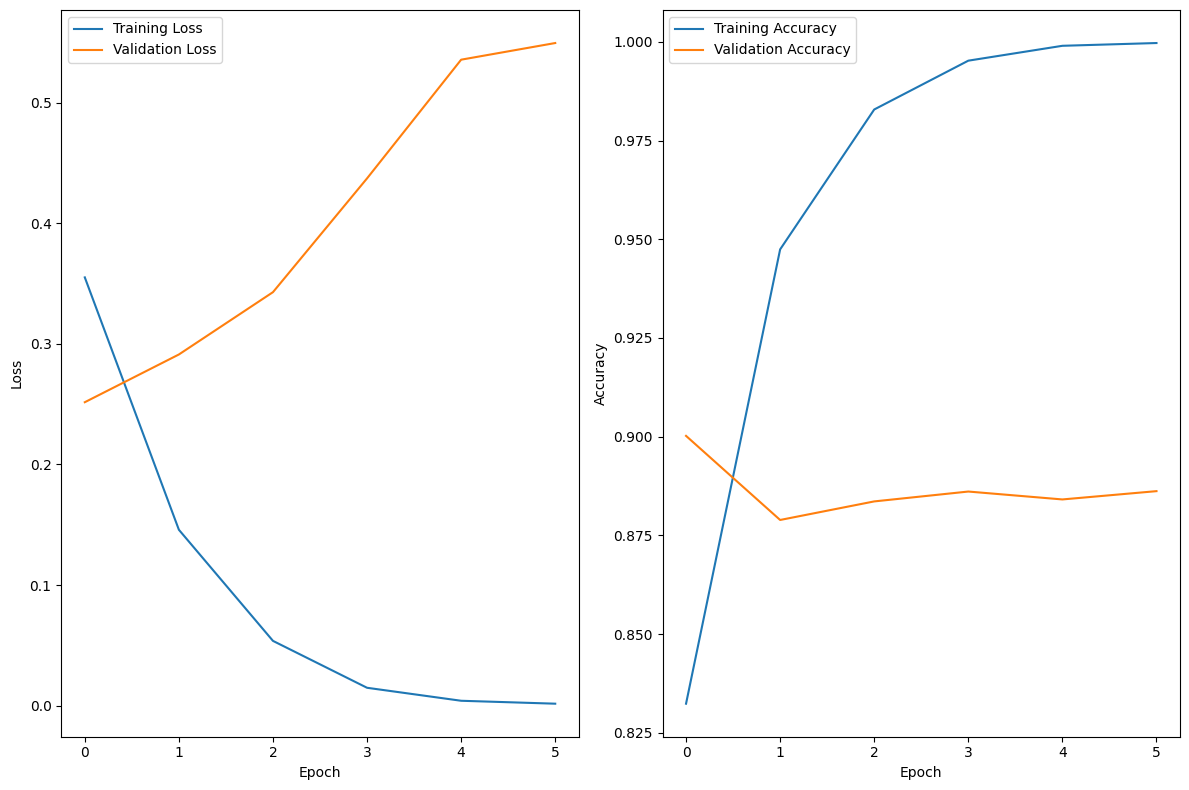

In [36]:
# Show Plot
history_plot(history)

313/313 [==============================] - 17s 54ms/step
---------- Evaluation Metrics for mchcnn_index_cleaned_stemmed_review ----------

F1 score: 0.884
Precision score: 0.882
Recall score: 0.886
Average precision-recall score: 0.838



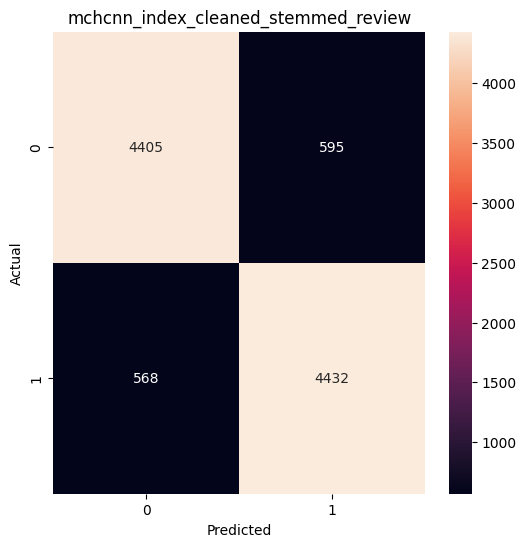

In [37]:
# Evaluate with test set
X_test_selected = X_test_dict['index_cleaned_stemmed_review']
predict_eval(multi_channel_cnn,  [X_test_selected, X_test_selected, X_test_selected, X_test_selected], y_test, 'mchcnn_index_cleaned_stemmed_review')

In [38]:
# TODO: If result of lstm+tfidf is better than lstm+index+embedding, then use tfidf for cnn as well

<a id="cnnlstm"></a>
### [2.4. CNN_LSTM](#content)

https://www.kaggle.com/code/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert

In [39]:
# TODO: Add code for CNN_LSTM
'''
def cnn_lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()
''' 
    
def create_cnn_lstm_model(tfidf=False):
    model = Sequential()
    if not tfidf:
        model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv1D(32,5,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(128,return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

with dist_strategy.scope():
    cnn_lstm_model_index = create_cnn_lstm_model()

cnn_lstm_model_index.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 batch_normalization (BatchN  (None, 500, 100)         400       
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 500, 100)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 496, 32)           16032     
                                                                 
 dropout_6 (Dropout)         (None, 496, 32)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 248, 32)          0         
 1D)                                                  

In [40]:
EPOCHS = 10
BATCH_SIZE = 32 * dist_strategy.num_replicas_in_sync # The number of input sequences in each batch
STEPS_PER_EPOCH =round(X_train_dict['index_cleaned_stemmed_review'].shape[0] / BATCH_SIZE) # The numebr of batches
ES = EarlyStopping(monitor='val_loss', patience=3)
MC = ModelCheckpoint('/kaggle/working/model_weights.h5', monitor='val_loss', save_best_only=True) 
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = cnn_lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                         y_train,
                         epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val),
                        callbacks=[ES, MC, LR]
)

Epoch 1/10
938/938 [==============================] - 1099s 1s/step - loss: 0.3982 - accuracy: 0.8103 - val_loss: 0.2625 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 2/10
938/938 [==============================] - 1092s 1s/step - loss: 0.2004 - accuracy: 0.9264 - val_loss: 0.2846 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 3/10
938/938 [==============================] - 1094s 1s/step - loss: 0.1208 - accuracy: 0.9582 - val_loss: 0.3479 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 4/10
938/938 [==============================] - 1094s 1s/step - loss: 0.0532 - accuracy: 0.9830 - val_loss: 0.4069 - val_accuracy: 0.8918 - lr: 2.0000e-04


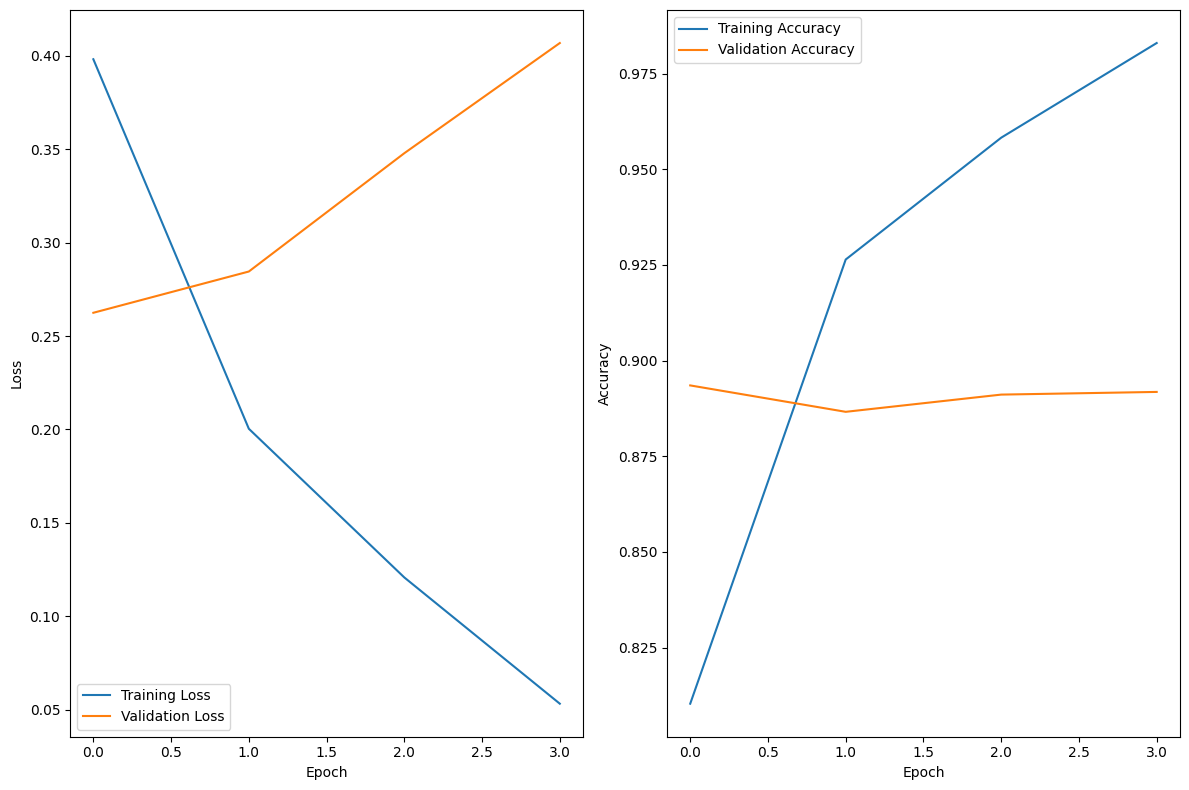

In [41]:
# Show Plot
history_plot(history)

313/313 [==============================] - 44s 139ms/step
---------- Evaluation Metrics for mchcnn_index_cleaned_stemmed_review ----------

F1 score: 0.892
Precision score: 0.903
Recall score: 0.882
Average precision-recall score: 0.856



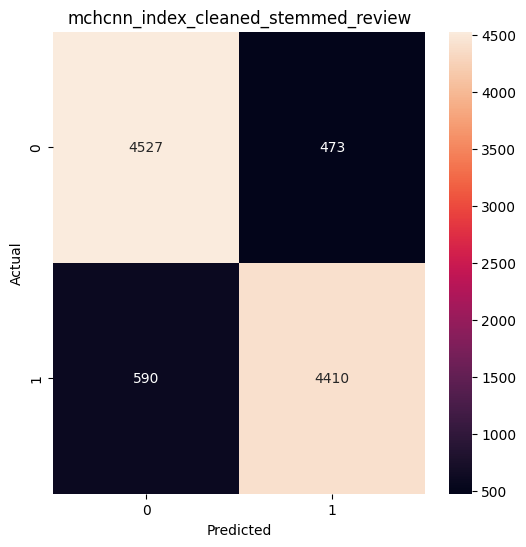

In [42]:
# Evaluate with test set
predict_eval(cnn_lstm_model_index,  X_test_dict['index_cleaned_stemmed_review'], y_test, 'mchcnn_index_cleaned_stemmed_review')

<a id="transformers"></a>
## [3. Transformers](#content)

For this section, we will be using a smaller dataset of Stanford Sentiment Treebank and compare the performance of different transformer architectures under the same comperatively smaller dataset.

Pytreebank will be used for loading sst data


Useful notebook for knowledge:"https://www.kaggle.com/code/maroberti/fastai-with-transformers-bert-roberta/notebook" (Code obsolete)

Huggingface auto classes
https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/auto#transformers.AutoModelForSequenceClassification

In [43]:
!pip install -q transformers

In [44]:
# https://walkwithfastai.com/nlp.external.transformers-glue
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from fastai.text.all import *

from datasets import load_dataset, concatenate_datasets
from inspect import signature
import gc


# Parameters
seed = 42
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

In [45]:
MODELS = [
      ('xlm-mlm-enfr-1024'   ,"XLMModel"),
      ('distilbert-base-cased', "DistilBertModel"),
      ('bert-base-uncased'     ,"BertModel"),
      ('roberta-base'        ,"RobertaModel"),
      ("cardiffnlp/twitter-roberta-base-sentiment","RobertaSentTW"),
      ('xlnet-base-cased'     ,"XLNetModel"),
      #('ctrl'                ,"CTRLModel"),
      ('transfo-xl-wt103'    ,"TransfoXLModel"),
      ('bert-base-cased'       ,"BertModelUncased"),
      ('xlm-roberta-base'     ,"XLMRobertaModel"),
      ('openai-gpt'           ,"OpenAIGPTModel"),
      ('gpt2'                 ,"GPT2Model")
]

To make switching between datasets smooth, define couple of dictionaries containing per-task information. We'll need metrics, text fields to retrieve data and number of outputs for the model.

In [46]:
GLUE_TASKS = ["cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]
def validate_task():
    assert task in GLUE_TASKS
    
glue_metrics = {
    'cola':[MatthewsCorrCoef()],
    'sst2':[accuracy],
    'mrpc':[F1Score(), accuracy],
    'stsb':[PearsonCorrCoef(), SpearmanCorrCoef()],
    'qqp' :[F1Score(), accuracy],
    'mnli':[accuracy],
    'qnli':[accuracy],
    'rte' :[accuracy],
    'wnli':[accuracy],
}

glue_textfields = {
    'cola':['sentence', None],
    'sst2':['sentence', None],
    'mrpc':['sentence1', 'sentence2'],
    'stsb':['sentence1', 'sentence2'],
    'qqp' :['question1', 'question2'],
    'mnli':['premise', 'hypothesis'],    
    'rte' :['sentence1', 'sentence2'],
    'wnli':['sentence1', 'sentence2'],
}

#ds_name='glue'
task = 'sst2'; validate_task()
ds = load_dataset('glue', task)

valid_ = 'validation-matched' if task=='mnli' else 'validation'
ds['train'].shape, ds[valid_].shape, ds['test'].shape

glue_num_labels = {'mnli':3, 'stsb':1}

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#### Data Preprocessing
Use number of characters a proxy for length of tokenized text to speed up dls creation.

In [47]:
USE_SMALL_DATASET=True

if USE_SMALL_DATASET:
    nv_init = int(len(ds['train'])/20)
    nt_init = nv_init * 2
    nt, nv = min(300, nt_init), min(150, nv_init)
    train_ds = ds['train'].select(range(nt+nv))
    test_ds = ds['train'].select(range(nt+nv, nt+2*nv))
else:
    nv = int(len(ds['train'])/5)
    nt = nv*4
    train_ds = ds['train']# concatenate_datasets([ds['train'], ds[valid_]])
    test_ds = ds[valid_]

train_idx, valid_idx = L(range(nt)), L(range(nt, nt+nv))
lens = train_ds.map(lambda s: {'len': sum([len(s[i]) for i in glue_textfields[task] if i])},
                    remove_columns=train_ds.column_names, num_proc=2, keep_in_memory=True)
train_lens = lens.select(train_idx)['len']
valid_lens = lens.select(valid_idx)['len']

#0:   0%|          | 0/225 [00:00<?, ?ex/s]

#1:   0%|          | 0/225 [00:00<?, ?ex/s]

TextGetter is analogous to ItemGetter but retrieves either one or two text fields from the source (e.g. "sentence1" and "sentence2").

Transformers expect two parts of text to be concatenated with some SEP token in between. But when displaying the batch it's better to have those texts in separate columns for better readability. To make it work I define a version of show_batch to be dispatched on the TransTensorText class. It will handle cases when there is single decoded text or a tuple of two texts.

In [48]:
class TextGetter(ItemTransform):
    def __init__(self, s1='text', s2=None):
        self.s1, self.s2 = s1, s2
    def encodes(self, sample):
        if self.s2 is None: return sample[self.s1]
        else: return sample[self.s1], sample[self.s2]
        
class TransTensorText(TensorBase): pass

@typedispatch
def show_batch(x:TransTensorText, y, samples, ctxs=None, max_n=10, trunc_at=150, **kwargs):
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    if isinstance(samples[0][0], tuple):
        samples = L((*s[0], *s[1:]) for s in samples)
        if trunc_at is not None: samples = L((s[0].truncate(trunc_at), s[1].truncate(trunc_at), *s[2:]) for s in samples)
    if trunc_at is not None: samples = L((s[0].truncate(trunc_at),*s[1:]) for s in samples)
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)
    display_df(pd.DataFrame(ctxs))

Tokenization of the inputs will be done by TokBatchTransform which wraps pre-trained HuggingFace tokenizer. The text processing is done in batches for speed-up. We want to awoid explicit python loops when possible.

In [49]:
class TokBatchTransform(Transform):
    """
    Tokenizes texts in batches using pretrained HuggingFace tokenizer.
    The first element in a batch can be single string or 2-tuple of strings.
    If `with_labels=True` the "labels" are added to the output dictionary.
    """
    def __init__(self, pretrained_model_name=None, tokenizer_cls=AutoTokenizer, 
                 config=None, tokenizer=None, with_labels=False,
                 padding=True, truncation=True, max_length=None, **kwargs):
        
        if tokenizer is None:
            tokenizer = tokenizer_cls.from_pretrained(pretrained_model_name, config=config)
        self.tokenizer = tokenizer
        self.kwargs = kwargs
        self._two_texts = False
        store_attr()
    
    def encodes(self, batch):
        # batch is a list of tuples of ({text or (text1, text2)}, {targets...})
        if is_listy(batch[0][0]): # 1st element is tuple
            self._two_texts = True
            texts = ([s[0][0] for s in batch], [s[0][1] for s in batch])
        elif is_listy(batch[0]): 
            texts = ([s[0] for s in batch],)

        inps = self.tokenizer(*texts,
                              add_special_tokens=True,
                              padding=self.padding,
                              truncation=self.truncation,
                              max_length=self.max_length,
                              return_tensors='pt',
                              **self.kwargs)
            
        # inps are batched, collate targets into batches too
        labels = default_collate([s[1:] for s in batch])
        if self.with_labels:
            inps['labels'] = labels[0]
            res = (inps, )
        else:
            res = (inps, ) + tuple(labels)
        return res
    
    def decodes(self, x:TransTensorText):
        if self._two_texts:
            x1, x2 = split_by_sep(x, self.tokenizer.sep_token_id)
            return (TitledStr(self.tokenizer.decode(x1.cpu(), skip_special_tokens=True)),
                    TitledStr(self.tokenizer.decode(x2.cpu(), skip_special_tokens=True)))
        

The batches processed by TokBatchTransform contain a dictionary as the first element. For decoding it's handy to have a tensor instead. The Undict transform fethces input_ids from the batch and creates TransTensorText which should work with typedispatch.

In [50]:
class Undict(Transform):
    def decodes(self, x:dict):
        if 'input_ids' in x: res = TransTensorText(x['input_ids'])
        return res

Now the transforms are to be combined inside a data block to be used for dls creation. The inputs are prebatched by TokBatchTranform so we don't need to use fa_collate for batching, so fa_convert is passed in as for "create_batch".

The texts we processing are of different lengths. Each sample in the batch is padded to the length of longest input to make them "collatable". Shuffling samples randomly will therefor result in getting longer batches on average. As the compute time depends on the sequence length this is udesired. SortedDL groups the inputs by length and if shuffle=True those are shuffled within certain interval keeping samples of similar length together.

#### Customized Learner
Now the xb we get from dataloader contains a dictionary and HuggingFace transformers accept keyword argument as input. But fastai Learner feeds the model with a sequence of positional arguments (self.pred = self.model(*self.xb)). To make this work smoothly we can create a callback to handle unrolling of the input dict into proper xb tuple.

But first we need to define some utility functions. default_splitter is used to divide model parameters into groups:

In [51]:
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

# Similar to show_batch one have to customize show_results:
@typedispatch
def show_results(x: TransTensorText, y, samples, outs, ctxs=None, max_n=10, trunc_at=150, **kwargs):
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    if isinstance(samples[0][0], tuple):
        samples = L((*s[0], *s[1:]) for s in samples)
        if trunc_at is not None: samples = L((s[0].truncate(trunc_at), s[1].truncate(trunc_at), *s[2:]) for s in samples)
    elif trunc_at is not None: samples = L((s[0].truncate(trunc_at),*s[1:]) for s in samples)
    ctxs = show_results[object](x, y, samples, outs, ctxs=ctxs, max_n=max_n, **kwargs)
    display_df(pd.DataFrame(ctxs))
    return ctxs

#TransLearner itself doesn't do much: 
#it adds TransCallback and sets splitter to be default_splitter if None is provided.
# Example usage: learn = TransLearner(dls, model, metrics=metrics, opt_func=opt_func)
@delegates(Learner.__init__)
class TransLearner(Learner):
    "Learner for training transformers from HuggingFace"
    def __init__(self, dls, model, **kwargs):
        splitter = kwargs.get('splitter', None)
        if splitter is None: kwargs['splitter'] = default_splitter
        super().__init__(dls, model, **kwargs)
        self.add_cb(TransCallback(model))

Main piece of work needed to train transformers model happens in TransCallback. It saves valid model argument and makes input dict yielded by dataloader into a tuple.

By default the model returns a dictionary-like object containing logits and possibly other outputs as defined by model config (e.g. intermediate hidden representations). In the fastai training loop we usually expect preds to be a tensor containing model predictions (logits). The callback formats the preds properly.

Notice that if labels are found in the input, transformer models compute the loss and return it together with output logits. The callback below is designed to utilise the loss returned by model instead of recomputing it using learn.loss_func. This is not actually used in this example but might be handy in some use cases.

In [52]:
class TransCallback(Callback):
    "Handles HuggingFace model inputs and outputs"
    
    def __init__(self, model):
        self.labels = tuple()
        self.model_args = {k:v.default for k, v in signature(model.forward).parameters.items()}
    
    def before_batch(self):
        if 'labels' in self.xb[0].keys():
            self.labels = (self.xb[0]['labels'], )
        # make a tuple containing an element for each argument model excepts
        # if argument is not in xb it is set to default value
        self.learn.xb = tuple([self.xb[0].get(k, self.model_args[k]) for k in self.model_args.keys()])
    
    def after_pred(self):
        if 'loss' in self.pred:
            self.learn.loss_grad = self.pred.loss
            self.learn.loss = self.pred.loss.clone()
        self.learn.pred = self.pred.logits
    
    def after_loss(self):
        if len(self.labels):
            self.learn.yb = self.labels
            self.labels = tuple()


<a id="trans_preproc"></a>
print_eval function defined under this section: [2.1. Naive Bayes Classification](#naive)

In [53]:
FOLDER = "fine_tuned_transformers/"
if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

# Train & Test
def train_binary_classification_task(model_name, bs=64, val_batch_size=32, opt_func = Adam, n_epoch = 5,lr = 2e-5):
    # Get tokenizer
    tok = TokBatchTransform(pretrained_model_name=model_name, max_length=512)
    
    needs_resize = False
    if tok.tokenizer.pad_token is None:
        needs_resize = True
        tok.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        
    # Get dataset loaders
    dls_kwargs = {
        'before_batch': tok,
        'create_batch': fa_convert
    }
    text_block = TransformBlock(dl_type=SortedDL, dls_kwargs=dls_kwargs, batch_tfms=Undict(), )

    dblock = DataBlock(blocks = [text_block, CategoryBlock()],
                       get_x=TextGetter(*glue_textfields[task]),
                       get_y=ItemGetter('label'),
                       splitter=IndexSplitter(valid_idx))
    
    dl_kwargs=[{'res':train_lens}, {'val_res':valid_lens}]
    dls = dblock.dataloaders(train_ds, bs=bs, val_bs=val_batch_size, dl_kwargs=dl_kwargs)
    
    # Get Model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=glue_num_labels.get(task, 2), ignore_mismatched_sizes=True)
    # Resize model tokenizer in case of Out Of Range index error
    
    if needs_resize:
        print("Needs token_embeddings resize")
        model.resize_token_embeddings(len(tok.tokenizer))
    
    # Get Learner
    learn = TransLearner(dls, 
                         model = model,
                         metrics=glue_metrics[task], 
                         opt_func=opt_func)    
    try:
        sug_lr = learn.lr_find() # somehow lr_find doesn't work for this model
    except:
        sug_lr = lr

    metrics = glue_metrics[task]
    metric_to_monitor = metrics[0].name if isinstance(metrics[0], Metric) else metrics[0].__name__
    cbs = [SaveModelCallback(monitor=metric_to_monitor)]
    learn.fit_one_cycle(n_epoch, sug_lr, cbs=cbs)
    learn.export(FOLDER+model_name.replace("/", "-"))

    #learn.show_results()

    test_dl = dls.test_dl(test_ds)
    preds = learn.get_preds(dl=test_dl)
    result = np.argmax(preds[0].numpy(), axis=1)
    print_eval(test_ds['label'],result, model_name)
    print("Prediction of the first sample", preds[0][0])
    
    del learn
    del dls
    print("Cleaned memory: ", gc.collect())

<a id="bert"></a>
### [3.1 BERT](#content)

Using huggingface pretrained model. This bert model is specifically trained for polarity classification. Pros: Well-established, strong performance. Cons: Relatively large model size. Good at general sentiment analysis.

https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/bert#transformers.BertForSequenceClassification

epoch,train_loss,valid_loss,accuracy,time
0,0.981056,0.736052,0.826667,00:49
1,0.792840,0.577126,0.833333,00:49
2,0.612707,0.497853,0.833333,00:47
3,0.504272,0.466453,0.833333,00:48
4,0.424780,0.460520,0.833333,00:48


Better model found at epoch 0 with accuracy value: 0.8266666531562805.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.


---------- Evaluation Metrics for textattack/bert-base-uncased-yelp-polarity ----------

F1 score: 0.800
Precision score: 0.817
Recall score: 0.784
Average precision-recall score: 0.747

Prediction of the first sample tensor([0.9199, 0.0801])
Cleaned memory:  1137


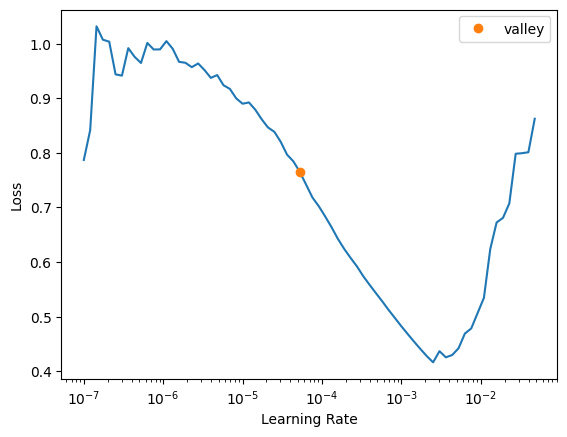

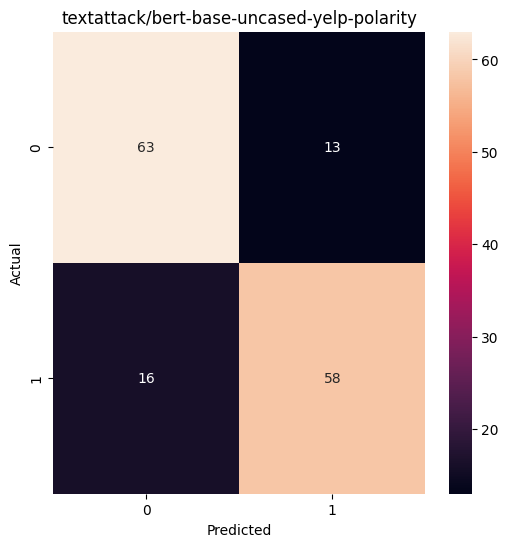

In [54]:
train_binary_classification_task("textattack/bert-base-uncased-yelp-polarity")

<a id="distilbert"></a>
### [3.2 DistilBERT](#content)

Using huggingface pretrained model.

- Pros: Smaller model, faster inference, reasonable performance.
- Cons: Slightly lower performance compared to BERT, but it's usually sufficient for sentiment analysis.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.691245,0.687799,0.613333,00:26
1,0.683567,0.659879,0.686667,00:27
2,0.663693,0.599620,0.773333,00:25
3,0.622328,0.564029,0.720000,00:29
4,0.585976,0.547540,0.733333,00:26


Better model found at epoch 0 with accuracy value: 0.6133333444595337.
Better model found at epoch 1 with accuracy value: 0.6866666674613953.
Better model found at epoch 2 with accuracy value: 0.7733333110809326.


---------- Evaluation Metrics for distilbert-base-uncased ----------

F1 score: 0.767
Precision score: 0.651
Recall score: 0.932
Average precision-recall score: 0.640

Prediction of the first sample tensor([0.4940, 0.5060])
Cleaned memory:  18608


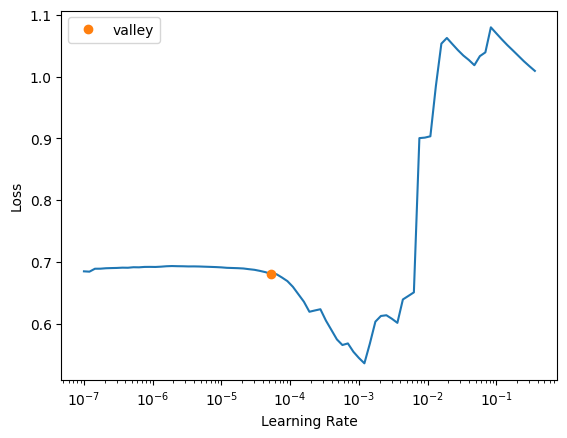

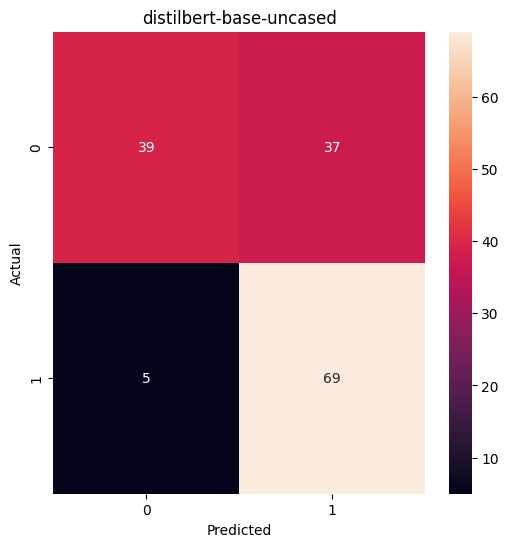

In [55]:
train_binary_classification_task("distilbert-base-uncased")

<a id="distilroberta"></a>
### [3.3. DistilRoBERTa](#content)

Using huggingface pretrained model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.720854,0.704101,0.533333,00:27
1,0.717455,0.691903,0.533333,00:30
2,0.711535,0.690103,0.533333,00:41
3,0.705929,0.691223,0.546667,00:40
4,0.704931,0.691451,0.646667,00:28


Better model found at epoch 0 with accuracy value: 0.5333333611488342.
Better model found at epoch 3 with accuracy value: 0.54666668176651.
Better model found at epoch 4 with accuracy value: 0.6466666460037231.


---------- Evaluation Metrics for distilroberta-base ----------

F1 score: 0.716
Precision score: 0.618
Recall score: 0.851
Average precision-recall score: 0.599

Prediction of the first sample tensor([0.4965, 0.5035])
Cleaned memory:  19659


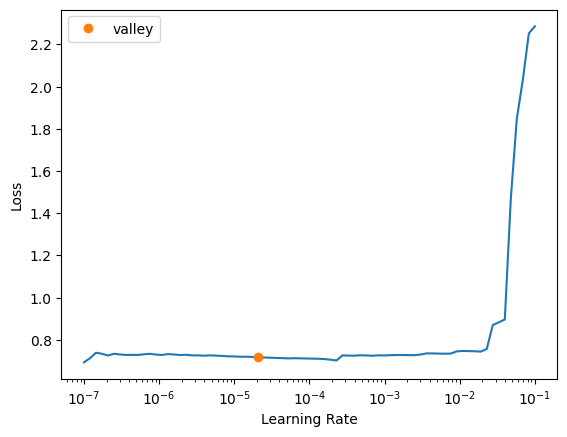

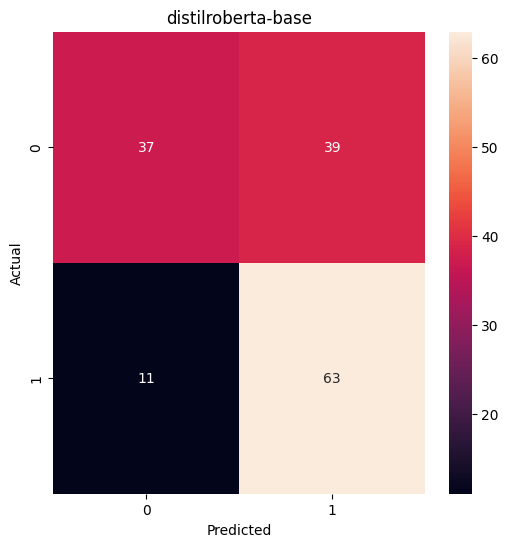

In [56]:
# Parameters
train_binary_classification_task("distilroberta-base")

<a id="bart"></a>
### [3.4 BART](#content)

Using huggingface pretrained model

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.725277,0.686404,0.533333,01:04
1,0.717818,0.685763,0.540000,01:03
2,0.700735,0.654328,0.620000,01:02
3,0.691317,0.646779,0.593333,01:02
4,0.680398,0.642016,0.606667,01:02


Better model found at epoch 0 with accuracy value: 0.5333333611488342.
Better model found at epoch 1 with accuracy value: 0.5400000214576721.
Better model found at epoch 2 with accuracy value: 0.6200000047683716.


---------- Evaluation Metrics for facebook/bart-base ----------

F1 score: 0.708
Precision score: 0.576
Recall score: 0.919
Average precision-recall score: 0.570

Prediction of the first sample tensor([0.4999, 0.5001])
Cleaned memory:  19523


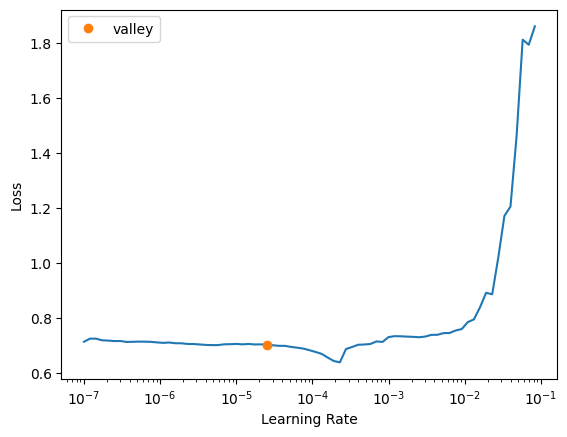

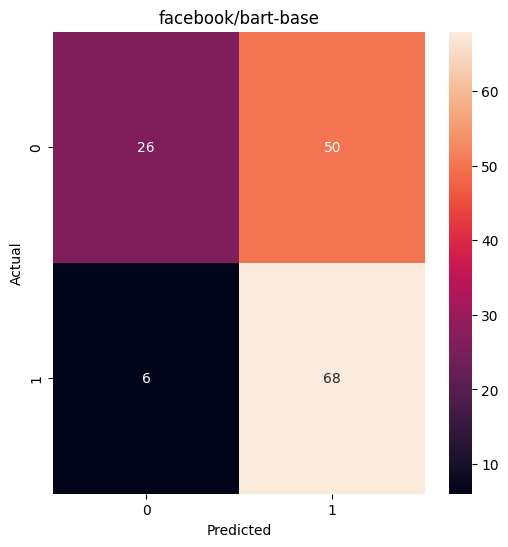

In [57]:
train_binary_classification_task("facebook/bart-base")#"valhalla/bart-large-sst2"

<a id="AlBERT"></a>
### [3.5 ALBERT](#content)

Using huggingface pretrained model

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.715254,0.690666,0.506667,00:54
1,0.698388,0.680114,0.560000,00:53
2,0.685684,0.664030,0.600000,00:54
3,0.673029,0.656671,0.626667,00:58
4,0.657522,0.654666,0.626667,00:54


Better model found at epoch 0 with accuracy value: 0.5066666603088379.
Better model found at epoch 1 with accuracy value: 0.5600000023841858.
Better model found at epoch 2 with accuracy value: 0.6000000238418579.
Better model found at epoch 3 with accuracy value: 0.6266666650772095.


---------- Evaluation Metrics for albert-base-v2 ----------

F1 score: 0.646
Precision score: 0.589
Recall score: 0.716
Average precision-recall score: 0.562

Prediction of the first sample tensor([0.4782, 0.5218])
Cleaned memory:  19328


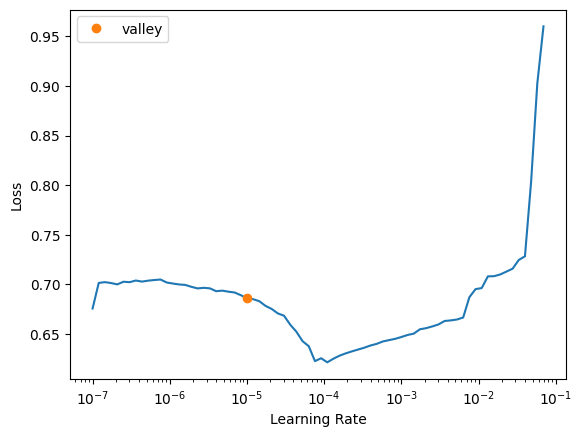

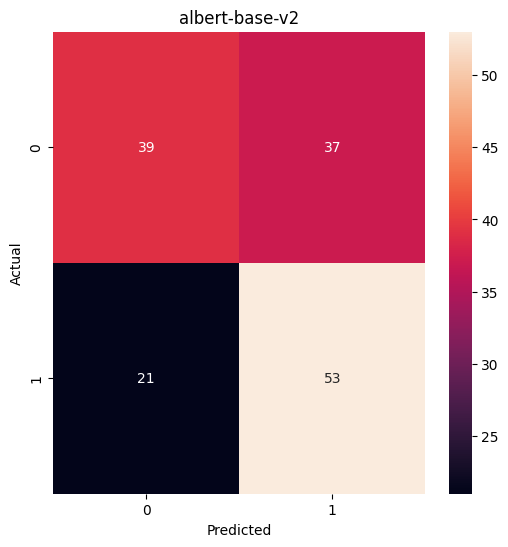

In [58]:
train_binary_classification_task("albert-base-v2")

<a id="ALBERTCls"></a>
### [3.6 ALBERT for Classification](#content)

Using huggingface pretrained model, to compare performance

epoch,train_loss,valid_loss,accuracy,time
0,0.464976,0.341510,0.873333,00:57
1,0.390512,0.349900,0.860000,00:55
2,0.304623,0.322747,0.893333,00:55
3,0.247893,0.319263,0.893333,00:55
4,0.210538,0.318670,0.900000,00:55


Better model found at epoch 0 with accuracy value: 0.8733333349227905.
Better model found at epoch 2 with accuracy value: 0.8933333158493042.
Better model found at epoch 4 with accuracy value: 0.8999999761581421.


---------- Evaluation Metrics for textattack/albert-base-v2-imdb ----------

F1 score: 0.865
Precision score: 0.827
Recall score: 0.905
Average precision-recall score: 0.796

Prediction of the first sample tensor([0.4313, 0.5687])
Cleaned memory:  18849


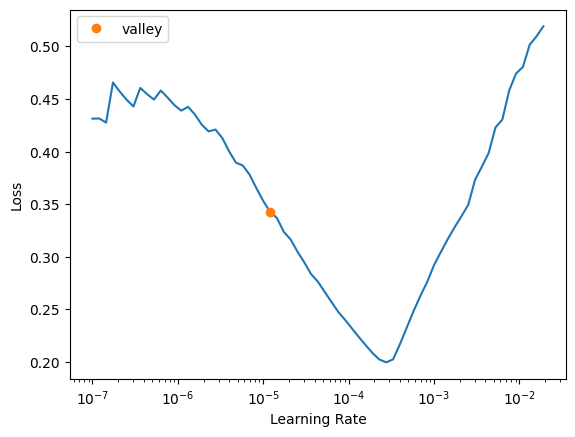

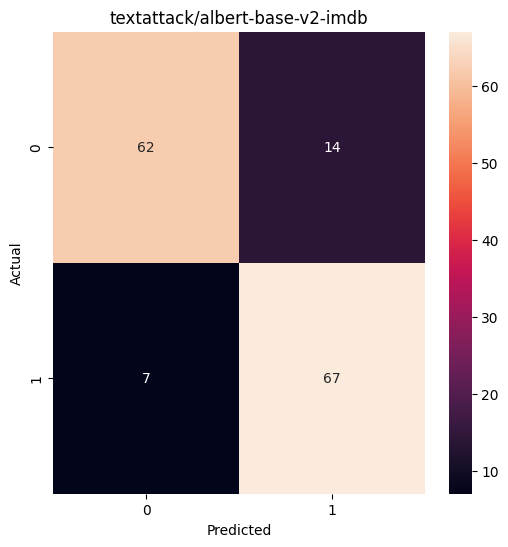

In [59]:
train_binary_classification_task("textattack/albert-base-v2-imdb")

<a id="DeBERTa"></a>
### [3.7 DeBERTa](#content)

Using huggingface pretrained model at
https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/gpt2#transformers.GPT2ForSequenceClassification

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.699335,0.693100,0.460000,00:59
1,0.695554,0.691737,0.566667,00:58
2,0.693571,0.685851,0.600000,00:58
3,0.689635,0.682776,0.633333,01:12
4,0.682004,0.682007,0.646667,01:06


Better model found at epoch 0 with accuracy value: 0.46000000834465027.
Better model found at epoch 1 with accuracy value: 0.5666666626930237.
Better model found at epoch 2 with accuracy value: 0.6000000238418579.
Better model found at epoch 3 with accuracy value: 0.6333333253860474.
Better model found at epoch 4 with accuracy value: 0.6466666460037231.


---------- Evaluation Metrics for microsoft/deberta-base ----------

F1 score: 0.667
Precision score: 0.614
Recall score: 0.730
Average precision-recall score: 0.581

Prediction of the first sample tensor([0.4809, 0.5191])
Cleaned memory:  18997


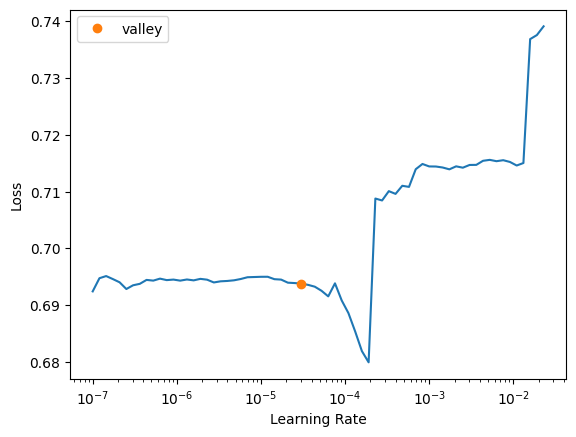

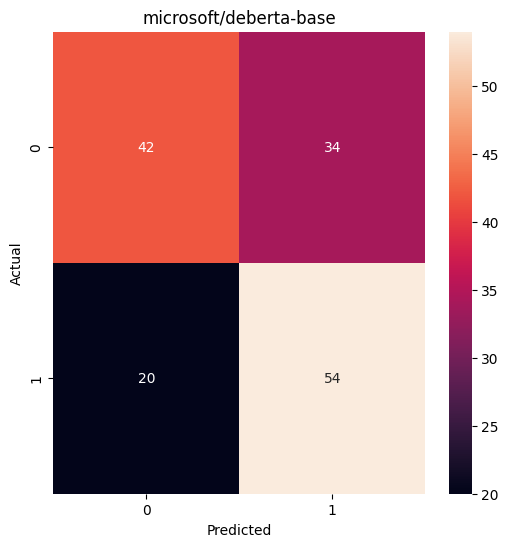

In [60]:
train_binary_classification_task("microsoft/deberta-base") 

<a id="Funnel"></a>
### [3.8 Funnel](#content)

Using huggingface pretrained model

https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/funnel#transformers.FunnelForSequenceClassification

Some weights of FunnelForSequenceClassification were not initialized from the model checkpoint at funnel-transformer/small-base and are newly initialized: ['classifier.linear_out.bias', 'classifier.linear_out.weight', 'classifier.linear_hidden.bias', 'classifier.linear_hidden.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,accuracy,time
0,0.694052,0.691361,0.533333,00:37
1,0.694476,0.690372,0.533333,00:38
2,0.692571,0.689447,0.533333,00:39
3,0.691899,0.688546,0.533333,00:38
4,0.691196,0.688249,0.533333,00:37


Better model found at epoch 0 with accuracy value: 0.5333333611488342.


---------- Evaluation Metrics for funnel-transformer/small-base ----------

F1 score: 0.655
Precision score: 0.490
Recall score: 0.986
Average precision-recall score: 0.490

Prediction of the first sample tensor([0.4887, 0.5113])
Cleaned memory:  19112


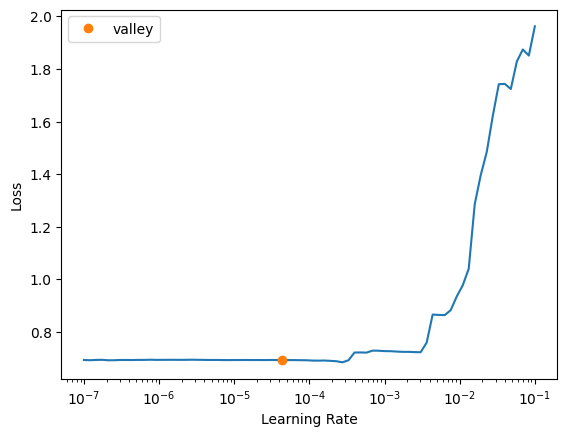

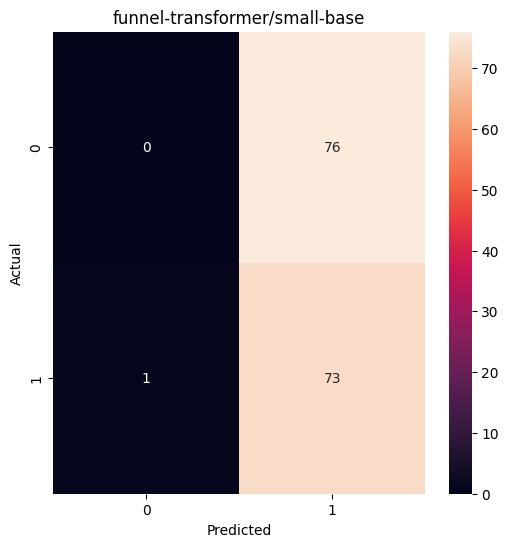

In [61]:
train_binary_classification_task("funnel-transformer/small-base")

<a id="gpt2"></a>
### [3.9 OpenAI GPT2](#content)

Using huggingface pretrained model at
https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/gpt2#transformers.GPT2ForSequenceClassification

In [62]:
#train_binary_classification_task("microsoft/DialogRPT-updown")

## Conclusion

Nice job, we made it! We took a ton of IMDB movie reviews, cleaned them up, and trained an LSTM model to figure out if they were positive or negative. Pretty cool, right?

Our model did pretty well, but there's always room for improvement. Maybe we can tweak some settings, add more layers, or even use a different type of model. Plus, we can always use more or different data to train on.

Remember, what matters most is not just the final accuracy number, but understanding what's happening along the way. Don't be afraid to play around with the code and try new things. Happy coding!